# Cancer Classification

In [1]:
import jax.numpy as np
import jax
from matplotlib import pyplot as plt
from jax.lib import xla_bridge
import ADAMLL as ada
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import  train_test_split 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
print("jax backend {}".format(xla_bridge.get_backend().platform))

key = jax.random.PRNGKey(2024)

jax backend gpu


## Data

In [2]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)

print("X_train shape {}".format(X_train.shape))
print("y_train shape {}".format(y_train.shape))
print("X_test shape {}".format(X_test.shape))
print("y_test shape {}".format(y_test.shape))

X_train shape (426, 30)
y_train shape (426, 1)
X_test shape (143, 30)
y_test shape (143, 1)


Training stopped after 299 epochs                                     

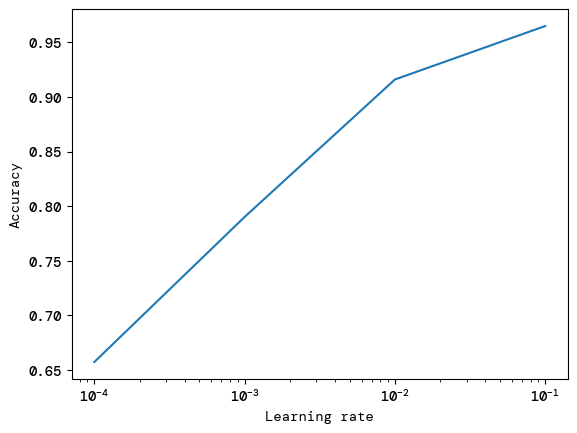

In [4]:

etas = [0.1, 0.01, 0.001, 0.0001]
accuracy = []
for eta in etas:
    #The NN has a single output node, the number of input nodes matches the number of features in the data
    #the NN becomes a logistic regression model
    network = ada.NN.Model(architecture=[[1, ada.activations.sigmoid]], eta=eta, epochs=300, optimizer='sgd', loss=ada.CE)
    network.fit(X_train,y_train, X_test, y_test)[0]
    accuracy.append(ada.accuracy(network.classify(X_test), y_test))

plt.plot(etas, accuracy)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()



In [ ]:
#Copied from the fys-stk4155 repository: https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week42.html#the-breast-cancer-data-now-with-keras

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as splitter
from sklearn.datasets import load_breast_cancer
import pickle
import os 


"""Load breast cancer dataset"""

np.random.seed(0)        #create same seed for random number every time

cancer=load_breast_cancer()      #Download breast cancer dataset

inputs=cancer.data                     #Feature matrix of 569 rows (samples) and 30 columns (parameters)
outputs=cancer.target                  #Label array of 569 rows (0 for benign and 1 for malignant)
labels=cancer.feature_names[0:30]

print('The content of the breast cancer dataset is:')      #Print information about the datasets
print(labels)
print('-------------------------')
print("inputs =  " + str(inputs.shape))
print("outputs =  " + str(outputs.shape))
print("labels =  "+ str(labels.shape))

x=inputs      #Reassign the Feature and Label matrices to other variables
y=outputs


# Visualisation of dataset (for correlation analysis)

plt.figure()
plt.scatter(x[:,0],x[:,2],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean radius',fontweight='bold')
plt.ylabel('Mean perimeter',fontweight='bold')
plt.show()

plt.figure()
plt.scatter(x[:,5],x[:,6],s=40,c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean compactness',fontweight='bold')
plt.ylabel('Mean concavity',fontweight='bold')
plt.show()


plt.figure()
plt.scatter(x[:,0],x[:,1],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean radius',fontweight='bold')
plt.ylabel('Mean texture',fontweight='bold')
plt.show()

plt.figure()
plt.scatter(x[:,2],x[:,1],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean perimeter',fontweight='bold')
plt.ylabel('Mean compactness',fontweight='bold')
plt.show()


# Generate training and testing datasets

#Select features relevant to classification (texture,perimeter,compactness and symmetery) 
#and add to input matrix

temp1=np.reshape(x[:,1],(len(x[:,1]),1))
temp2=np.reshape(x[:,2],(len(x[:,2]),1))
X=np.hstack((temp1,temp2))      
temp=np.reshape(x[:,5],(len(x[:,5]),1))
X=np.hstack((X,temp))       
temp=np.reshape(x[:,8],(len(x[:,8]),1))
X=np.hstack((X,temp))       

X_train,X_test,y_train,y_test=splitter(X,y,test_size=0.1)   #Split datasets into training and testing

y_train=to_categorical(y_train)     #Convert labels to categorical when using categorical cross entropy
y_test=to_categorical(y_test)

del temp1,temp2,temp

# Define tunable parameters"

eta=np.logspace(-3,-1,3)                    #Define vector of learning rates (parameter to SGD optimiser)
lamda=0.01                                  #Define hyperparameter
n_layers=2                                  #Define number of hidden layers in the model
n_neuron=np.logspace(0,3,4,dtype=int)       #Define number of neurons per layer
epochs=100                                   #Number of reiterations over the input data
batch_size=100                              #Number of samples per gradient update



"""Define function to return Deep Neural Network model"""

def NN_model(inputsize,n_layers,n_neuron,eta,lamda):
    model=Sequential()      
    for i in range(n_layers):       #Run loop to add hidden layers to the model
        if (i==0):                  #First layer requires input dimensions
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda),input_dim=inputsize))
        else:                       #Subsequent layers are capable of automatic shape inferencing
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda)))
    model.add(Dense(2,activation='softmax'))  #2 outputs - ordered and disordered (softmax for prob)
    sgd=optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
    return model

    
Train_accuracy=np.zeros((len(n_neuron),len(eta)))      #Define matrices to store accuracy scores as a function
Test_accuracy=np.zeros((len(n_neuron),len(eta)))       #of learning rate and number of hidden neurons for 

for i in range(len(n_neuron)):     #run loops over hidden neurons and learning rates to calculate 
    for j in range(len(eta)):      #accuracy scores 
        DNN_model=NN_model(X_train.shape[1],n_layers,n_neuron[i],eta[j],lamda)
        DNN_model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1)
        Train_accuracy[i,j]=DNN_model.evaluate(X_train,y_train)[1]
        Test_accuracy[i,j]=DNN_model.evaluate(X_test,y_test)[1]
               

def plot_data(x,y,data,title=None):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)
    if title is not None:
        ax.set_title(title)

    plt.tight_layout()

    plt.show()
    
plot_data(eta,n_neuron,Train_accuracy, 'training')
plot_data(eta,n_neuron,Test_accuracy, 'testing')

In [ ]:
#Copied from the fys-stk4155 repository: https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter4.html

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))